Messing around with Twitter API and PANDAS

# Load tweets into a text file

In [1]:
import tweepy
import config 
import json
from tweepy import OAuthHandler

auth = OAuthHandler(config.consumer_key,config.consumer_secret)
auth.set_access_token(config.access_token,config.access_secret)
api = tweepy.API(auth)

def store(tweet):
    output.write(json.dumps(tweet)+'\n')

file_name = 'trumptweets.json'
output = open(file_name,"w")

num_tweets = 2500                  # number of tweets to retrieve
twitter_id = 'realDonaldTrump'     # userid 

for tweet in tweepy.Cursor(api.user_timeline, id=twitter_id).items(num_tweets):
    store(tweet._json)
    
output.close()


# Parse JSON data

In [2]:
import json
import pandas as pd 

def load_tweets(file):
    with open(file,'r') as f:
        tweets = (json.loads(line) for i, line in enumerate(f.readlines()))
    return tweets

# Select the attributes needed
data = {'text': [], 'created_at': [], 'retweet_count': [], 'favorite_count': [], 'followers_count': []}
        
tweets = load_tweets(file_name)
for t in tweets:
    data['text'].append(t['text'])
    data['retweet_count'].append(t['retweet_count'])
    data['created_at'].append(t['created_at'])
    data['favorite_count'].append(t['favorite_count'])
    data['followers_count'].append(t['user']['followers_count'])
    
df = pd.DataFrame(data)
df['created_at'] = pd.to_datetime(df['created_at']) # convert to datetime data type

df.sort_values(by='created_at') 

,created_at,favorite_count,followers_count,retweet_count,text
2499,2016-05-27 14:10:07,12747,25598574,4897,AN AMERICA FIRST ENERGY PLAN\n#MakeAmericaGrea...
2498,2016-05-27 17:35:56,10372,25598574,2964,Bill O'Reilly doing a major special on @Oreill...
2497,2016-05-27 23:19:20,8278,25598574,1955,"I am on @oreillyfactor tonight, a big special...."
2496,2016-05-27 23:20:01,21448,25598574,7196,"Wow- 25,000 in San Diego, California!\nThank y..."
2495,2016-05-28 02:19:19,16723,25598574,4653,Thank you @BillyJoel- many friends just told m...
2494,2016-05-28 02:48:22,25535,25598574,7377,.@SanDiegoPD- Fantastic job on handling the th...
2493,2016-05-28 04:13:54,10436,25598574,5036,Obama administration fails to screen Syrian re...
2492,2016-05-28 06:19:54,17426,25598574,4681,"Great rally in Fresno, California- great crowd..."
2491,2016-05-28 13:47:10,18565,25598574,6834,The U.S. has 69 treaties with other countries ...
2490,2016-05-28 14:47:16,27086,25598574,7689,I (we) broke the all-time record for most vote...


# Looking at Favorite and Retweet Counts

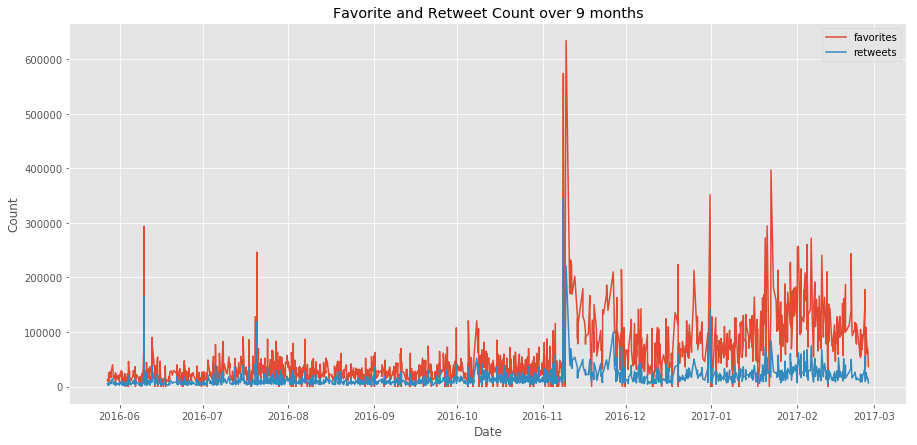

In [22]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize = (15,7))
num_days = (max(df['created_at']) - min(df['created_at'])).days
num_months = int(num_days/30)
plt.title('Favorite and Retweet Count over ' + str(num_months) + ' months')
plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(df['created_at'],df['favorite_count'],label='favorite count')
plt.plot(df['created_at'],df['retweet_count'],label='retweet count')
plt.legend(['favorites','retweets'])
plt.show()

In [32]:
max_favorite_count = max(df['favorite_count'])
most_favorited_tweet = df.ix[df['favorite_count'].idxmax()]['text']

print("Donald Trump's most favorited tweet with " + str(max_favorite_count) + " tweets:\n" + most_favorited_tweet)

Donald Trump's most favorited tweet with 633812 tweets:
Such a beautiful and important evening! The forgotten man and woman will never be forgotten again. We will all come together as never before


# Account Activity